In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
from fastai import *
from fastai.vision import *
# from fastai.callbacks import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config

from dsin.train_utils.visibilty_utils.logger_cb_utils import setup_file_logger
from dsin.train_utils.visibilty_utils.pbar_cb_utils import (AverageMetric,
                                            ParameterMetricCallback,
                                            ProgressBarAttibuteVisualizer,
                                            ParameterRunningAverageMetricCallback,
                                            BitEntropy
                                           )
from dsin.train_utils.save_utils import FileNameGenerator

In [6]:
config.H_target = 2* 0.3
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [7]:
logger = setup_file_logger()

In [8]:
config.use_si_flag = SiNetChannelIn.WithSideInformation

In [9]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 #0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)


tfms =  get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1., max_lighting=None, max_warp=None, p_affine=0.0, p_lighting=0.0)

batchsize = 1

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 1224), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(baseline_autoencoder,SiNetChannelIn.NoSideInformation),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [10]:
model_fname =FileNameGenerator.create_fname('MAE-l2reg-baseline')
lrs = [0.1 **(4 + i //2)  for i in range(5)]
model_fname,lrs

('2020-08-26-16-09MAE-l2reg-baseline',
 [0.00010000000000000002,
  0.00010000000000000002,
  1.0000000000000003e-05,
  1.0000000000000003e-05,
  1.0000000000000004e-06])

In [ ]:
config.si_loss_weight_alpha = 0
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
    
for i,lr in enumerate(lrs):
    if i != 0 :
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=False)])

    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.095 imp-mean-var(0.49 0.25) total loss1432.5  l2reg_loss=37.1autoencoder_loss_value=86.4si_loss=0.0feat_loss_value=0.0


In [ ]:
learn.save(f'{model_fname}-{i}')

!aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
!aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


In [ ]:
learn.model.my_tuple[5]


In [ ]:
learn.data.train_ds[1][0].img

In [ ]:
learn.data.train_ds[1][0].si_img

In [ ]:
learn.loss_func.soft_bit_entropy

In [ ]:
config.si_loss_weight_alpha

In [ ]:
learn.loss_func.autoencoder_loss_value

In [14]:
learn.load('200816MAE-l2reg-baseline-1')


Learner(data=ImageDataBunch;

Train: LabelList (32232 items)
x: SideinformationImageImageList
ImageSiTuple [tensor([[[0.0510, 0.0509, 0.0469,  ..., 0.0744, 0.0742, 0.0682],
         [0.0500, 0.0490, 0.0460,  ..., 0.0744, 0.0870, 0.0863],
         [0.0632, 0.0632, 0.0550,  ..., 0.0803, 0.0970, 0.0954],
         ...,
         [0.4774, 0.4916, 0.5268,  ..., 0.0719, 0.0666, 0.0665],
         [0.4755, 0.4795, 0.4908,  ..., 0.0835, 0.0795, 0.0795],
         [0.4715, 0.4685, 0.4693,  ..., 0.0951, 0.1034, 0.1005]],

        [[0.0558, 0.0541, 0.0581,  ..., 0.0765, 0.0888, 0.1143],
         [0.0646, 0.0567, 0.0570,  ..., 0.0859, 0.1016, 0.1352],
         [0.0813, 0.0805, 0.0727,  ..., 0.1047, 0.1216, 0.1519],
         ...,
         [0.4961, 0.5002, 0.5121,  ..., 0.0882, 0.0785, 0.0627],
         [0.4793, 0.4982, 0.5110,  ..., 0.1064, 0.0915, 0.0835],
         [0.4775, 0.4951, 0.5007,  ..., 0.1098, 0.1033, 0.1113]],

        [[0.0754, 0.0618, 0.0570,  ..., 0.0867, 0.0833, 0.0959],
         [0.076

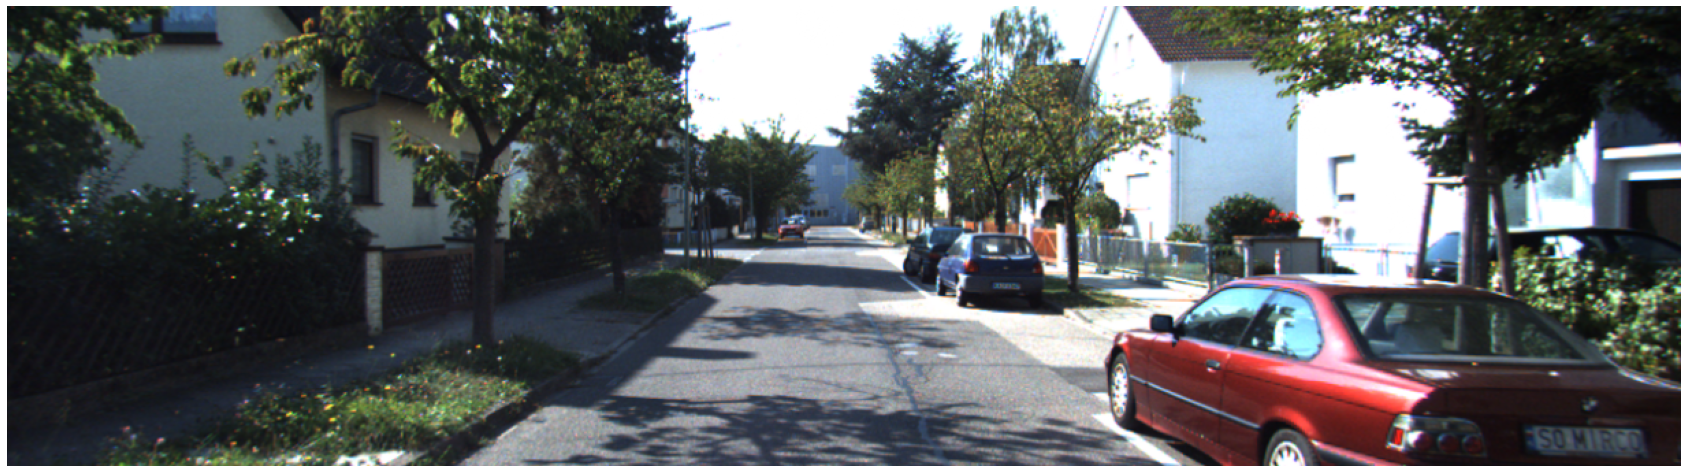

In [20]:
mt = learn.model.my_tuple[-1].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
show_image(Image(mt),figsize=(30,30))
# # print(mn)

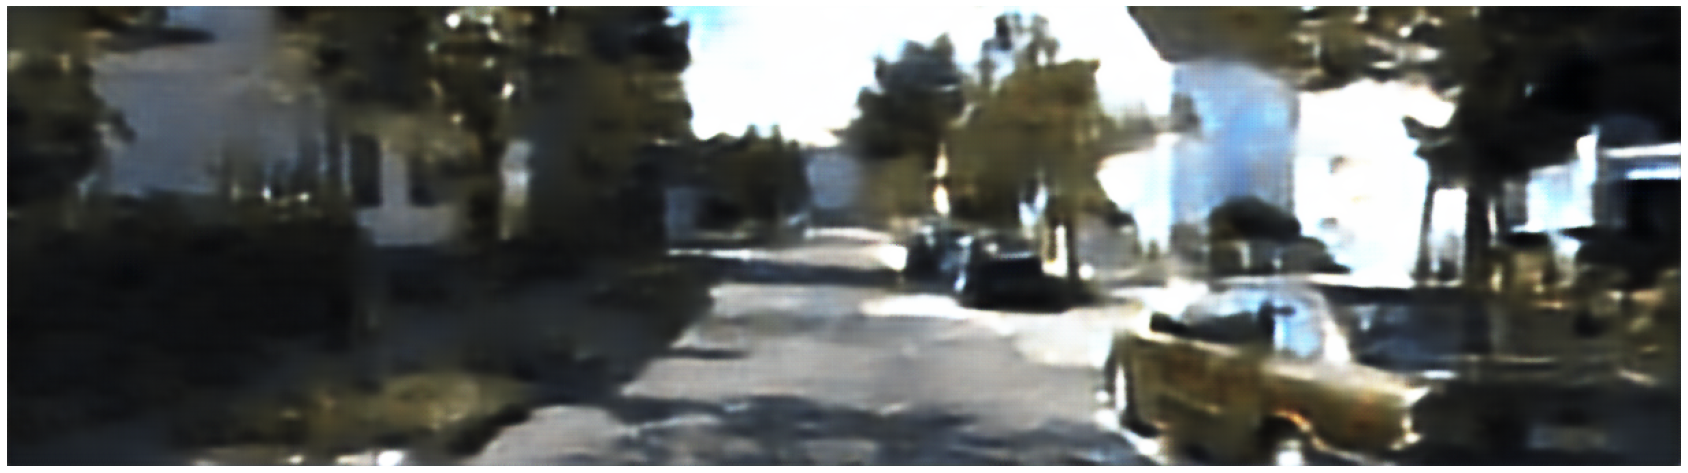

In [21]:
mt = learn.model.my_tuple[0].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
show_image(Image(mt),figsize=(30,30))